In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings

#=================================================
# Modify paths to point to output files
#=================================================
# Case name (Straight coast)
case_straight = 'Straight Coast'

# path to ocean_annual file
path_year_straight = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/800yr/26000101.ocean_annual.nc'
dy_straight = xr.open_dataset(path_year_straight, decode_times=True)

# path to ocean_month file
path_month_straight = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/800yr/26000101.ocean_month.nc'
dm_straight = xr.open_dataset(path_month_straight, decode_times=True)

# path to ice_month file
path_month_straight = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/800yr/26000101.ice_month.nc'
di_straight = xr.open_dataset(path_month_straight, decode_times=True)


# Case name (Both Coast)
case_both = 'Both Coast'

# path to ocean_annual file
path_year_both = '/data/sragen/aquaplanet/MASTERS/both_coast/run/DATA/800yr/26000101.ocean_annual.nc'
dy_both = xr.open_dataset(path_year_both, decode_times=True)

# path to ocean_month file
path_month_both = '/data/sragen/aquaplanet/MASTERS/both_coast/run/DATA/800yr/26000101.ocean_month.nc'
dm_both = xr.open_dataset(path_month_both, decode_times=True)

# path to ice_month file
path_month_both = '/data/sragen/aquaplanet/MASTERS/both_coast/run/DATA/800yr/26000101.ice_month.nc'
di_both = xr.open_dataset(path_month_both, decode_times=True)


# Case name (Wide Straight)
case_wide = 'Wide Straight'

# path to ocean_annual file
path_year_wide = '/data/sragen/aquaplanet/MASTERS/wide_straight/run/DATA/200yr/20000101.ocean_annual.nc'
dy_wide = xr.open_dataset(path_year_wide, decode_times=True)

# path to ocean_month file
path_month_wide = '/data/sragen/aquaplanet/MASTERS/wide_straight/run/DATA/200yr/20000101.ocean_month.nc'
dm_wide = xr.open_dataset(path_month_wide, decode_times=True)

# path to ice_month file
path_month_wide = '/data/sragen/aquaplanet/MASTERS/wide_straight/run/DATA/200yr/20000101.ice_month.nc'
di_wide = xr.open_dataset(path_month_wide, decode_times=True)


# Case name (America Coast)
case_am = 'America Coast'

# path to ocean_annual file
path_year_am = '/data/sragen/aquaplanet/MASTERS/am_coast/run/DATA/500yr/23000101.ocean_annual.nc'
dy_am = xr.open_dataset(path_year_am, decode_times=True)

# path to ocean_month file
path_month_am = '/data/sragen/aquaplanet/MASTERS/am_coast/run/DATA/500yr/23000101.ocean_month.nc'
dm_am = xr.open_dataset(path_month_am, decode_times=True)

# path to ice_month file
path_month_am = '/data/sragen/aquaplanet/MASTERS/am_coast/run/DATA/500yr/23000101.ice_month.nc'
di_am = xr.open_dataset(path_month_am, decode_times=True)


# Case name (Africa Coast)
case_af = 'Africa Coast'

# path to ocean_annual file
path_year_af = '/data/sragen/aquaplanet/MASTERS/af_coast/run/DATA/500yr/23000101.ocean_annual.nc'
dy_af = xr.open_dataset(path_year_af, decode_times=True)

# path to ocean_month file
path_month_af = '/data/sragen/aquaplanet/MASTERS/af_coast/run/DATA/500yr/23000101.ocean_month.nc'
dm_af = xr.open_dataset(path_month_af, decode_times=True)

# path to ice_month file
path_month_af = '/data/sragen/aquaplanet/MASTERS/af_coast/run/DATA/500yr/23000101.ice_month.nc'
di_af = xr.open_dataset(path_month_af, decode_times=True)


#=================================================
# Ignore runtime warnings: mean of empty slice
#=================================================
warnings.filterwarnings("ignore", message="Mean of empty slice")

#=================================================
# Modify latitudes to point to western and eastern
# boundaries of small basin and northern extent of SO.
# Comment out for AQUA and RIDGE cases. 
#=================================================
x_west = np.where(dy_straight['xh']==211)[0][0]
x_east = np.where(dy_straight['xh']==351)[0][0]
y = np.where(dy_straight['yq']==-35)[0][0]
y_south = np.where(dy_straight['yq']==-71)[0][0]
y_north = np.where(dy_straight['yq']==71)[0][0]

/home/sragen/.conda/envs/aqua/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [9]:
# functions
def calculate_OHT(T_ady_2d, T_diffy_2d):
    tady = np.where(np.abs(T_ady_2d) == 1e+20, np.nan, T_ady_2d)
    tady_avg = np.nanmean(tady, axis=0)
    tady_zonal = np.nansum(tady_avg, axis=1)
    tdiffy = np.where(np.abs(T_diffy_2d) == 1e+20, np.nan, T_diffy_2d)
    tdiffy_avg = np.nanmean(tdiffy, axis=0)
    tdiffy_zonal = np.nansum(tdiffy_avg, axis=1)
    OHT = (tady_zonal + tdiffy_zonal)/1e15
    return OHT

def calculate_basin_sfn(vmo, vhGM, x_west, x_east, y_south, y_north):
    vmo_slice = (np.nanmean(vmo[-31:-1,:,:,:], axis=0))
    vhGM_slice = (np.nanmean(vhGM[-31:-1,:,:,:], axis=0))
    sfn_basin_mean = (np.cumsum(np.nansum((vmo_slice[:,y_south:y_north,x_west:x_east])/1025, axis=2), axis=0))/(1e6)
    sfn_basin_res = (np.cumsum(np.nansum((vhGM_slice[:,y_south:y_north,x_west:x_east])/1025, axis=2), axis=0))/(1e6)
    sfn_basin_resmean = sfn_basin_mean + sfn_basin_res
    return sfn_basin_mean, sfn_basin_res, sfn_basin_resmean

def variablename(*arg):
    names = []
    for i in range(len(arg)):
        item = [tpl[0] for tpl in filter(lambda x: arg[i] is x[1], globals().items())]
        names.append(item)
    str(names).strip('[]')
    return names

def plot_basin_sfn(sfn_1, sfn_2, sfn_3, sfn_bound, y_south, y_north):
    lat = dy_straight['yq']; z = dy_straight['zl']
    t = np.linspace(-sfn_bound, sfn_bound, 11, endpoint=True)
    b = np.linspace(-sfn_bound, sfn_bound, 21, endpoint=True)
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
    sfn_list = sfn_1, sfn_2, sfn_3
    names = variablename(sfn_1, sfn_2, sfn_3)
    for row in range(3):
        ax = axs[row]
        cf = ax.contourf(lat[y_south:y_north], z, sfn_list[row][:,:], b, cmap='coolwarm', extend='both')
        ax.invert_yaxis()
        ax.set_xlim(lat[y_south], lat[y_north-1])
        ax.set_title('{}'.format(str(names[row]).strip("['']")), fontsize=16)
        cbar = fig.colorbar(cf, ax=ax, ticks=t, format = '%.0f')
        cbar.ax.set_ylabel('[Sv]', fontsize=12)
    axs[1].set_ylabel('Depth', fontsize=14), axs[2].set_xlabel('Latitude', fontsize=14)
#     plt.savefig(fig_path+'{}.png'.format(sname))
#     plt.show()
    return


def plot_surface_diffs(case1, case2, name1, name2):
    sst_diff = case1['tos'].mean(dim='time') - case2['tos'].mean(dim='time')
    sss_diff = case1['sos'].mean(dim='time') - case2['sos'].mean(dim='time')
    ssh_diff = case1['zos'].mean(dim='time') - case2['zos'].mean(dim='time')
    
    x_west = np.where(dy_straight['xh']==211)[0][0]
    x_east = np.where(dy_straight['xh']==351)[0][0]

    b = np.linspace(-2, 2, 21, endpoint=True)
    t = np.linspace(-2, 2, 11, endpoint=True)
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
    plt.contourf(case1['xh'], case1['yh'], sst_diff, b, 
             cmap='RdBu_r', extend='both',transform=ccrs.PlateCarree())
    cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
    cbar.ax.set_ylabel('[$^\circ$C]', fontsize=14)
    plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
    plt.title('{} - {} SST'.format(name1, name2), fontsize=16)
    # plt.savefig(fig_path+'SST.png')
    plt.show()

    plt.subplots(figsize=(8,5))
    plt.plot(case1['yh'], np.nanmean(sst_diff, axis=1), linewidth=2, label='Global Mean')
    # Following two lines are for configurations with more than one basin
    plt.plot(case1['yh'], np.nanmean(sst_diff[:,x_west:x_east], axis=1), '--',linewidth=2, label='Small Basin')
    plt.plot(case1['yh'], np.nanmean(sst_diff[:,:x_west], axis=1), '--', linewidth=2, label='Large Basin')
    #
    plt.ylabel('[C]', fontsize=14), plt.xlabel('Latitude', fontsize=14)
    plt.title('{} - {} SST'.format(name1, name2), fontsize=16)
    plt.grid()
    plt.legend()
    # plt.savefig(fig_path+'SST_section.png')
    plt.show()

    b_salt = np.linspace(-1, 1, 21, endpoint=True)
    t_salt = np.linspace(-1, 1, 11, endpoint=True)
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
    plt.contourf(case1['xh'], case1['yh'], sss_diff, b_salt, 
             cmap='BrBG_r', extend='both', transform=ccrs.PlateCarree())
    cbar = plt.colorbar(ticks=t_salt, boundaries=t_salt, spacing='uniform', extend='both')
    cbar.ax.set_ylabel('[$^\circ$C]', fontsize=14)
    plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
    plt.title('{} - {} SSS'.format(name1, name2), fontsize=16)
    # plt.savefig(fig_path+'SSS.png')
    plt.show()

    plt.subplots(figsize=(8,5))
    plt.plot(case1['yh'], np.nanmean(sss_diff, axis=1), linewidth=2, label='Global Mean')
    # Following two lines are for configurations with more than one basin
    plt.plot(case1['yh'], np.nanmean(sss_diff[:,x_west:x_east], axis=1), '--', linewidth=2, label='Small Basin')
    plt.plot(case1['yh'], np.nanmean(sss_diff[:,:x_west], axis=1), '--', linewidth=2, label='Large Basin')
    #
    plt.ylabel('[psu]', fontsize=14), plt.xlabel('Latitude', fontsize=14)
    plt.title('{} - {} SSS'.format(name1, name2), fontsize=16)
    plt.grid()
    plt.legend()
    # plt.savefig(fig_path+'SSS_section.png')
    plt.show()

    b_ssh = np.linspace(-0.4, 0.4, 21, endpoint=True)
    t_ssh = np.linspace(-0.4, 0.4, 11, endpoint=True)
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
    plt.contourf(case1['xh'], case1['yh'], ssh_diff, b_ssh, 
             cmap='PRGn', extend='both', transform=ccrs.PlateCarree())
    cbar = plt.colorbar(ticks=t_ssh, boundaries=t_ssh, spacing='uniform', extend='both')
    cbar.ax.set_ylabel('[m]', fontsize=14)
    plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
    plt.title('{} - {} SSH'.format(name1, name2), fontsize=16)
    # plt.savefig(fig_path+'SSS.png')
    plt.show()
    return



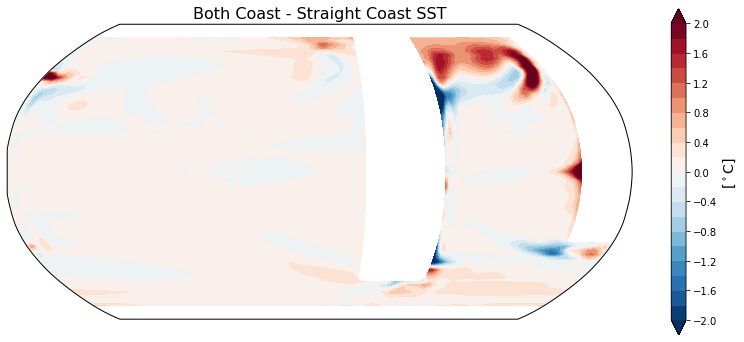

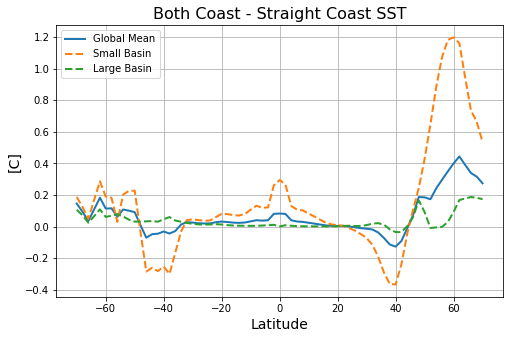

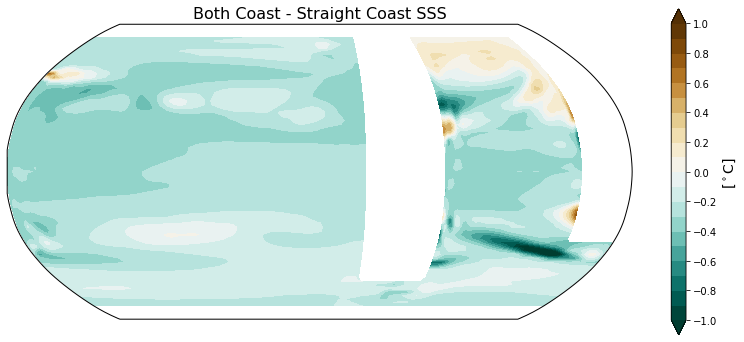

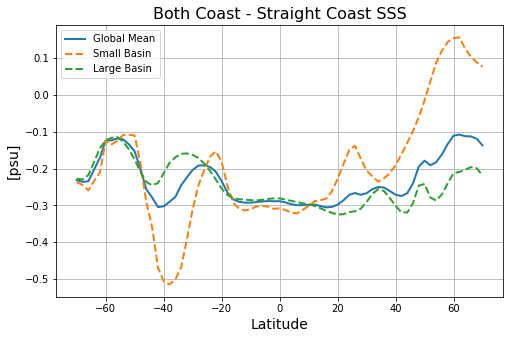

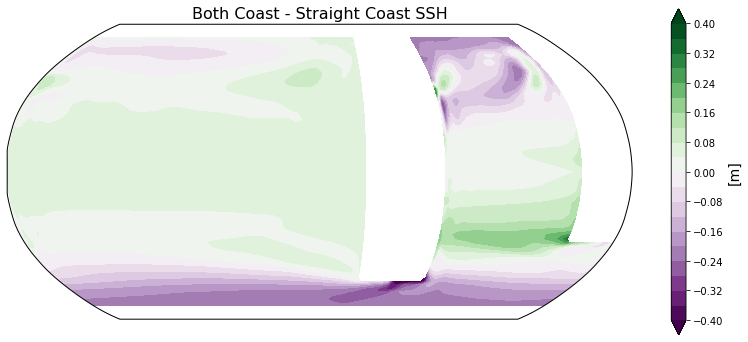

In [10]:
plot_surface_diffs(dy_both, dy_straight, case_both, case_straight)

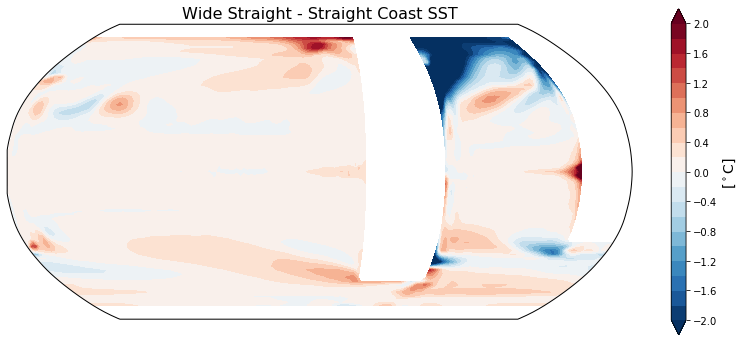

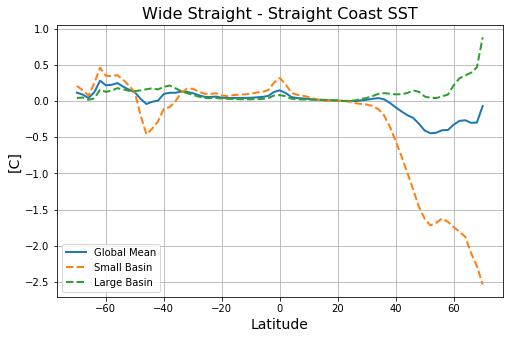

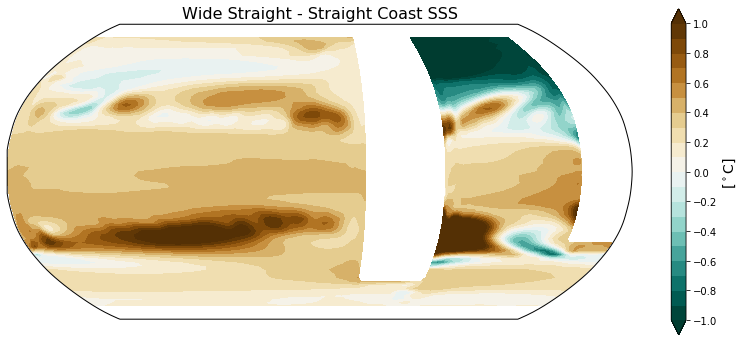

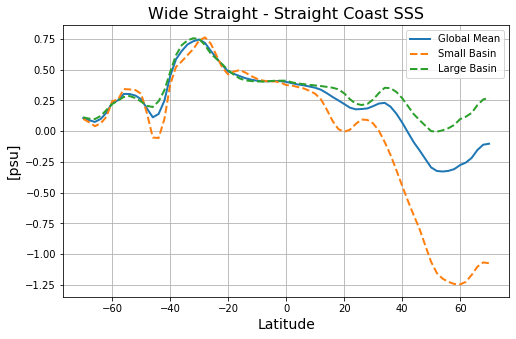

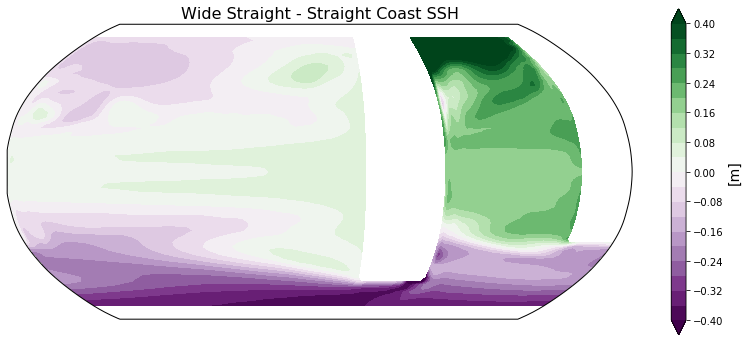

In [12]:
plot_surface_diffs(dy_wide, dy_straight, case_wide, case_straight)

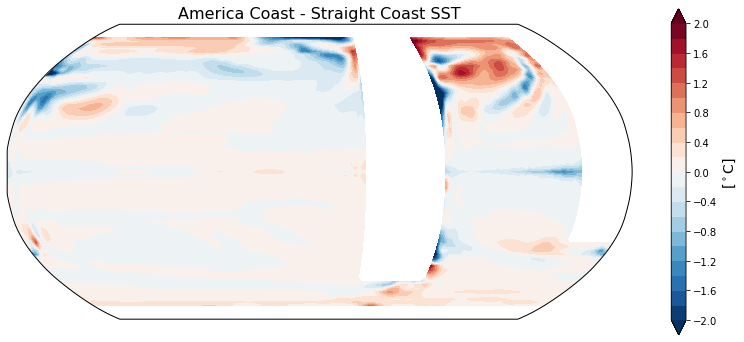

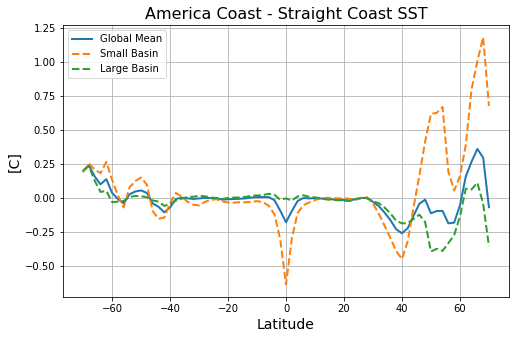

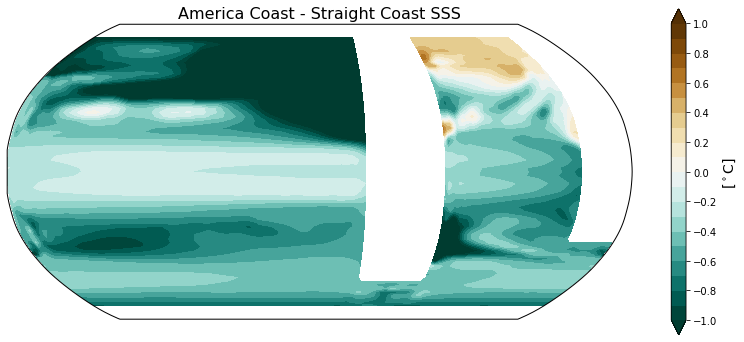

In [ ]:
plot_surface_diffs(dy_am, dy_straight, case_am, case_straight)

In [ ]:
plot_surface_diffs(dy_af, dy_straight, case_af, case_straight)

In [ ]:
plot_surface_diffs(dy_af, dy_both, case_af, case_both)

In [ ]:
plot_surface_diffs(dy_am, dy_both, case_am, case_both)

In [ ]:
plot_surface_diffs(dy_af, dy_both, case_af, case_both)

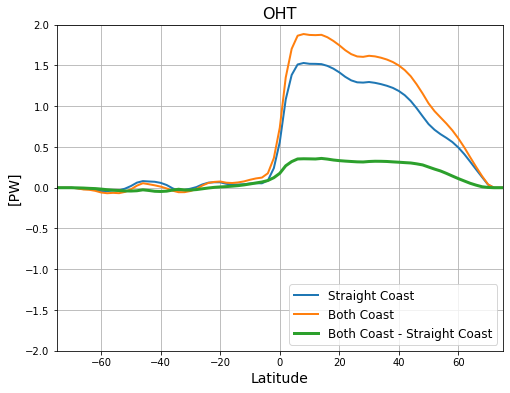

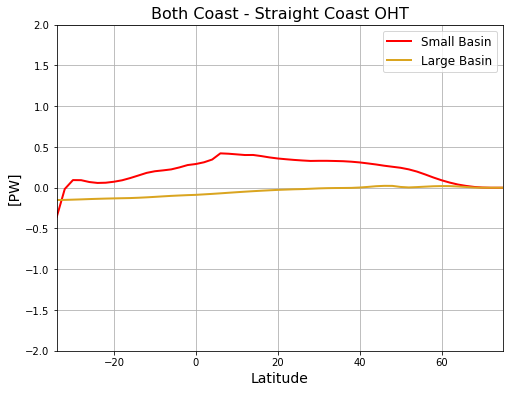

In [13]:
OHT_straight = calculate_OHT(dm_straight['T_ady_2d'], dm_straight['T_diffy_2d'])
OHT_both = calculate_OHT(dm_both['T_ady_2d'], dm_both['T_diffy_2d'])
OHT = OHT_both - OHT_straight

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_straight, linewidth=2, label=case_straight)
ax.plot(dm_both['yq']+1, OHT_both, linewidth=2, label=case_both)
ax.plot(dm_straight['yq']+1, OHT, linewidth=3, label='{} - {}'.format(case_both, case_straight))
plt.title('OHT', fontsize=16)
plt.grid()
plt.xlim(-75,75)
plt.ylim(-2, 2)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_global.png')
plt.show()

OHT_small_straight = calculate_OHT(dm_straight['T_ady_2d'][:,:,x_west:x_east], 
                                   dm_straight['T_diffy_2d'][:,:,x_west:x_east])
OHT_large_straight = calculate_OHT(dm_straight['T_ady_2d'][:,:,:x_west], dm_straight['T_diffy_2d'][:,:,:x_west])
OHT_small_both = calculate_OHT(dm_both['T_ady_2d'][:,:,x_west:x_east], 
                                   dm_both['T_diffy_2d'][:,:,x_west:x_east])
OHT_large_both = calculate_OHT(dm_both['T_ady_2d'][:,:,:x_west], dm_both['T_diffy_2d'][:,:,:x_west])

OHT_small = OHT_small_both - OHT_small_straight
OHT_large = OHT_large_both - OHT_large_straight

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_small, color='red', linewidth=2, label='Small Basin')
ax.plot(dm_straight['yq']+1, OHT_large, color='goldenrod', linewidth=2, label='Large Basin')
plt.title('{} - {} OHT'.format(case_both, case_straight), fontsize=16)
plt.grid()
plt.xlim(-34,75)
plt.ylim(-2, 2)
plt.legend(fontsize=12)
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_basins.png')
plt.show()

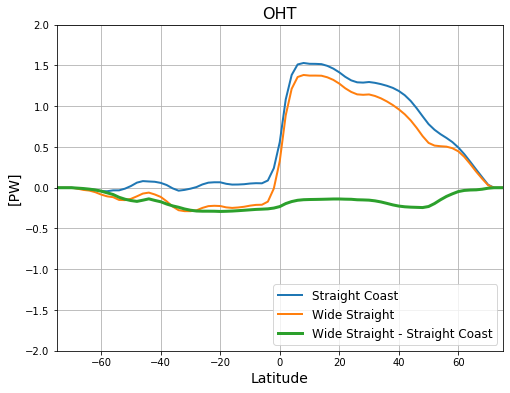

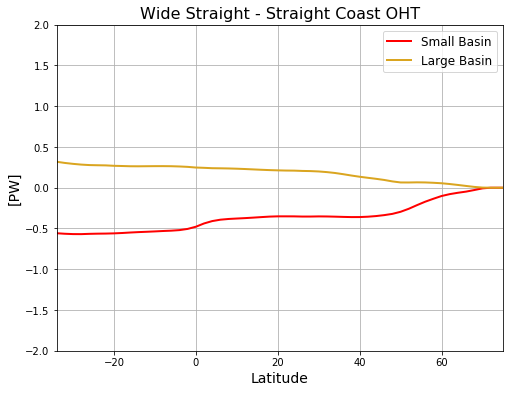

In [14]:
OHT_straight = calculate_OHT(dm_straight['T_ady_2d'], dm_straight['T_diffy_2d'])
OHT_wide = calculate_OHT(dm_wide['T_ady_2d'], dm_wide['T_diffy_2d'])
OHT = OHT_wide - OHT_straight

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_straight, linewidth=2, label=case_straight)
ax.plot(dm_wide['yq']+1, OHT_wide, linewidth=2, label=case_wide)
ax.plot(dm_straight['yq']+1, OHT, linewidth=3, label='{} - {}'.format(case_wide, case_straight))
plt.title('OHT', fontsize=16)
plt.grid()
plt.xlim(-75,75)
plt.ylim(-2, 2)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_global.png')
plt.show()

OHT_small_straight = calculate_OHT(dm_straight['T_ady_2d'][:,:,x_west:x_east], 
                                   dm_straight['T_diffy_2d'][:,:,x_west:x_east])
OHT_large_straight = calculate_OHT(dm_straight['T_ady_2d'][:,:,:x_west], dm_straight['T_diffy_2d'][:,:,:x_west])
OHT_small_wide = calculate_OHT(dm_wide['T_ady_2d'][:,:,x_west:x_east], 
                                   dm_wide['T_diffy_2d'][:,:,x_west:x_east])
OHT_large_wide = calculate_OHT(dm_wide['T_ady_2d'][:,:,:x_west], dm_wide['T_diffy_2d'][:,:,:x_west])

OHT_small = OHT_small_wide - OHT_small_straight
OHT_large = OHT_large_wide - OHT_large_straight

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_small, color='red', linewidth=2, label='Small Basin')
ax.plot(dm_straight['yq']+1, OHT_large, color='goldenrod', linewidth=2, label='Large Basin')
plt.title('{} - {} OHT'.format(case_wide, case_straight), fontsize=16)
plt.grid()
plt.xlim(-34,75)
plt.ylim(-2, 2)
plt.legend(fontsize=12)
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_basins.png')
plt.show()

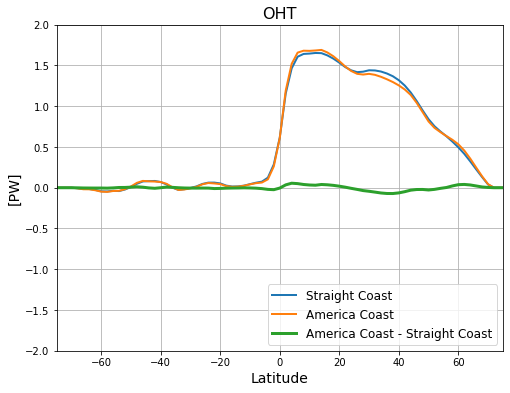

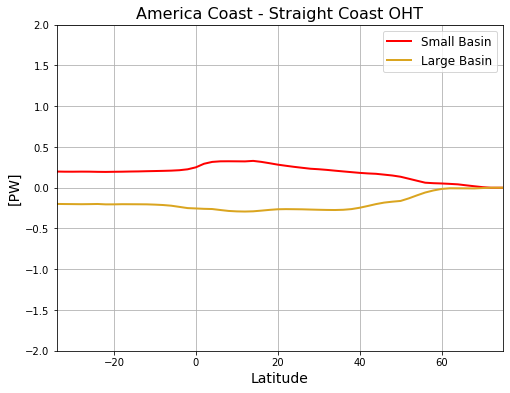

In [14]:
T_ady_2d_am = dm_am['T_ady'].sum(dim='zl')

OHT_am = calculate_OHT(T_ady_2d_am, dm_am['T_diffy_2d'])
# OHT_am = calculate_OHT(dm_am['T_ady_2d'], dm_am['T_diffy_2d'])

OHT = OHT_am - OHT_straight

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_straight, linewidth=2, label=case_straight)
ax.plot(dm_am['yq']+1, OHT_am, linewidth=2, label=case_am)
ax.plot(dm_straight['yq']+1, OHT, linewidth=3, label='{} - {}'.format(case_am, case_straight))
plt.title('OHT', fontsize=16)
plt.grid()
plt.xlim(-75,75)
plt.ylim(-2, 2)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_global.png')
plt.show()

OHT_small_am = calculate_OHT(T_ady_2d_am[:,:,x_west:x_east], 
                                   dm_am['T_diffy_2d'][:,:,x_west:x_east])
OHT_large_am = calculate_OHT(T_ady_2d_am[:,:,:x_west], dm_am['T_diffy_2d'][:,:,:x_west])

OHT_small = OHT_small_am - OHT_small_straight
OHT_large = OHT_large_am - OHT_large_straight 

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_small, color='red', linewidth=2, label='Small Basin')
ax.plot(dm_straight['yq']+1, OHT_large, color='goldenrod', linewidth=2, label='Large Basin')
plt.title('{} - {} OHT'.format(case_am, case_straight), fontsize=16)
plt.grid()
plt.xlim(-34,75)
plt.ylim(-2, 2)
plt.legend(fontsize=12)
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_basins.png')
plt.show()


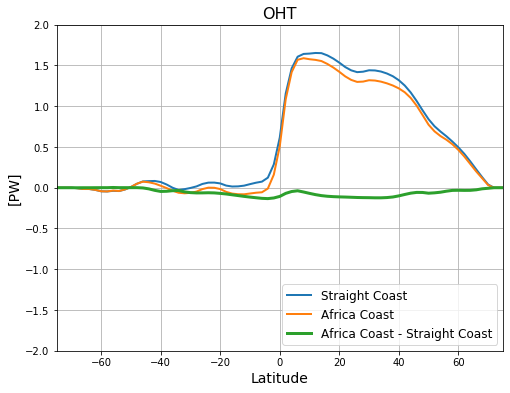

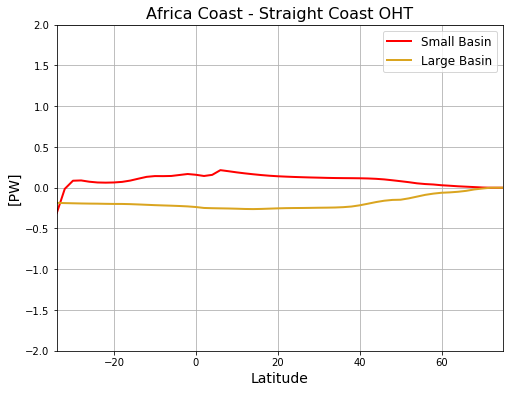

In [15]:
T_ady_2d_af = dm_af['T_ady'].sum(dim='zl')

OHT_af = calculate_OHT(dm_af['T_ady_2d'], dm_af['T_diffy_2d'])

OHT = OHT_af - OHT_straight

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_straight, linewidth=2, label=case_straight)
ax.plot(dm_af['yq']+1, OHT_af, linewidth=2, label=case_af)
ax.plot(dm_straight['yq']+1, OHT, linewidth=3, label='{} - {}'.format(case_af, case_straight))
plt.title('OHT', fontsize=16)
plt.grid()
plt.xlim(-75,75)
plt.ylim(-2, 2)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_global.png')
plt.show()

# OHT_small_straight = calculate_OHT(dm_straight['T_ady_2d'][:,:,x_west:x_east], 
#                                    dm_straight['T_diffy_2d'][:,:,x_west:x_east])
# OHT_large_straight = calculate_OHT(dm_straight['T_ady_2d'][:,:,:x_west], dm_straight['T_diffy_2d'][:,:,:x_west])
OHT_small_af = calculate_OHT(T_ady_2d_af[:,:,x_west:x_east], 
                                   dm_af['T_diffy_2d'][:,:,x_west:x_east])
OHT_large_af = calculate_OHT(T_ady_2d_af[:,:,:x_west], dm_af['T_diffy_2d'][:,:,:x_west])

OHT_small = OHT_small_af - OHT_small_straight
OHT_large = OHT_large_af - OHT_large_straight 

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_small, color='red', linewidth=2, label='Small Basin')
ax.plot(dm_straight['yq']+1, OHT_large, color='goldenrod', linewidth=2, label='Large Basin')
plt.title('{} - {} OHT'.format(case_af, case_straight), fontsize=16)
plt.grid()
plt.xlim(-34,75)
plt.ylim(-2, 2)
plt.legend(fontsize=12)
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_basins.png')
plt.show()

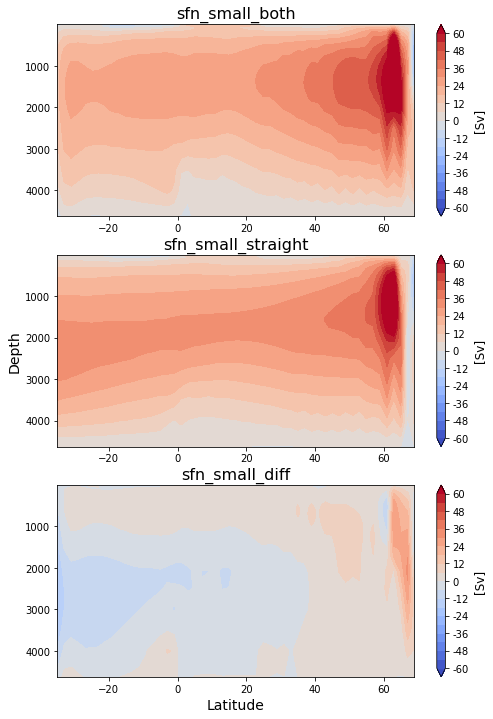

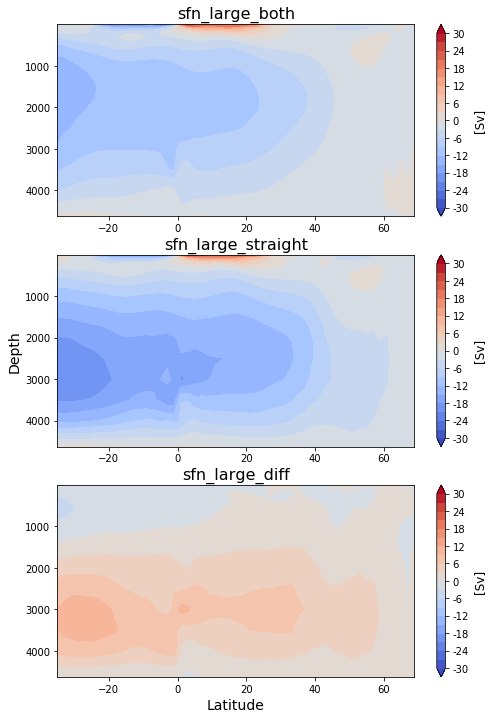

In [16]:
x, x, sfn_small_straight = calculate_basin_sfn(dy_straight['vmo'], dy_straight['vhGM'], x_west, x_east, y, y_north)
x, x, sfn_large_straight = calculate_basin_sfn(dy_straight['vmo'], dy_straight['vhGM'], 0, x_west, y, y_north)

x, x, sfn_small_both = calculate_basin_sfn(dy_both['vmo'], dy_both['vhGM'], x_west, x_east, y, y_north)
x, x, sfn_large_both = calculate_basin_sfn(dy_both['vmo'], dy_both['vhGM'], 0, x_west, y, y_north)

sfn_small_diff = sfn_small_both - sfn_small_straight
sfn_large_diff = sfn_large_both - sfn_large_straight

plot_basin_sfn(sfn_small_both, sfn_small_straight, sfn_small_diff, 60, y, y_north)
plot_basin_sfn(sfn_large_both,sfn_large_straight, sfn_large_diff, 30, y, y_north)

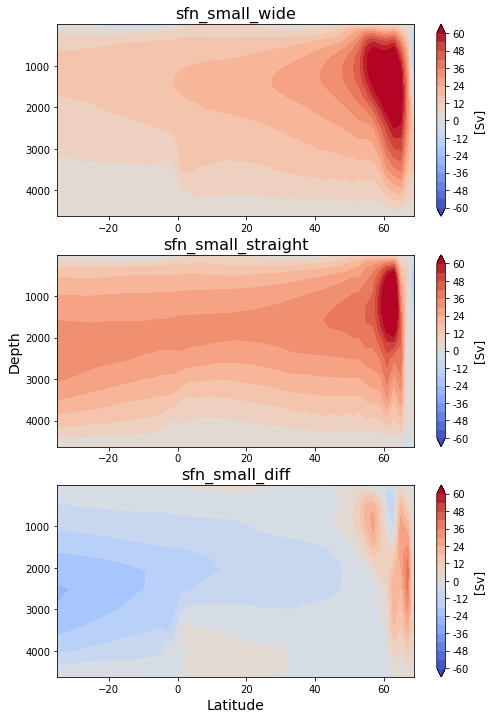

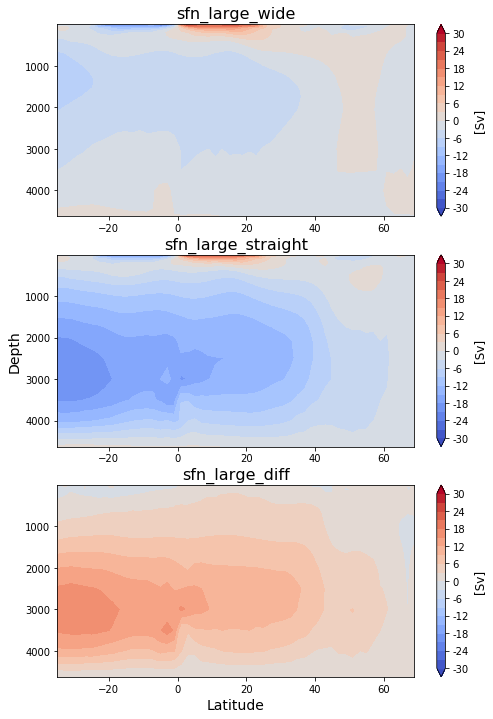

In [17]:
x, x, sfn_small_straight = calculate_basin_sfn(dy_straight['vmo'], dy_straight['vhGM'], x_west, x_east, y, y_north)
x, x, sfn_large_straight = calculate_basin_sfn(dy_straight['vmo'], dy_straight['vhGM'], 0, x_west, y, y_north)

x, x, sfn_small_wide = calculate_basin_sfn(dy_wide['vmo'], dy_wide['vhGM'], x_west, x_east, y, y_north)
x, x, sfn_large_wide = calculate_basin_sfn(dy_wide['vmo'], dy_wide['vhGM'], 0, x_west, y, y_north)

sfn_small_diff = sfn_small_wide - sfn_small_straight
sfn_large_diff = sfn_large_wide - sfn_large_straight

plot_basin_sfn(sfn_small_wide, sfn_small_straight, sfn_small_diff, 60, y, y_north)
plot_basin_sfn(sfn_large_wide,sfn_large_straight, sfn_large_diff, 30, y, y_north)

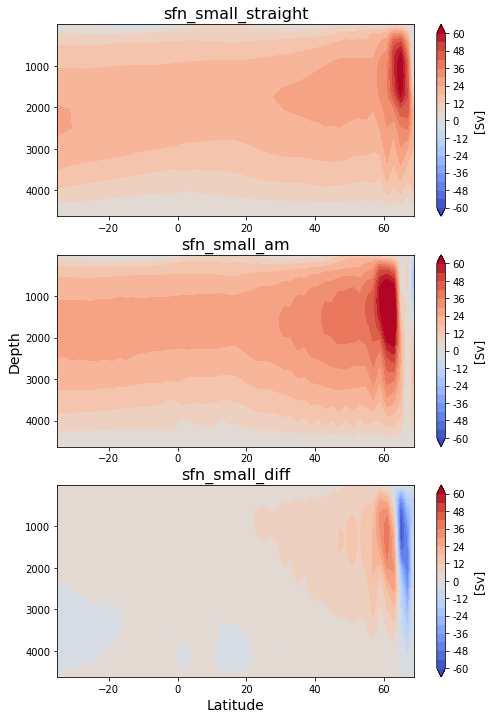

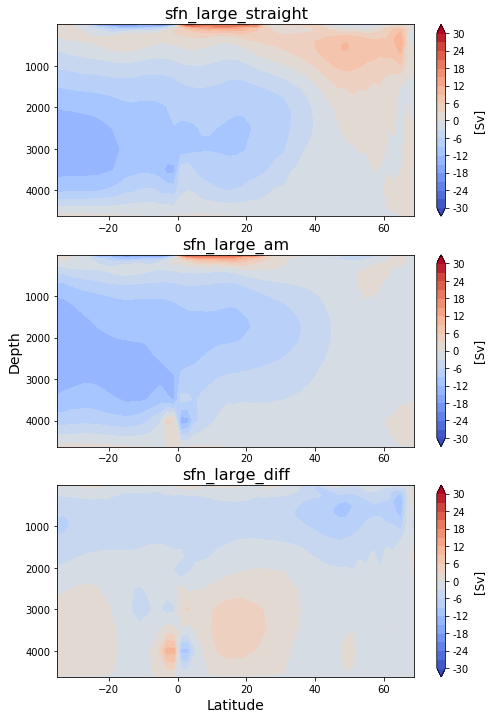

In [17]:
x, x, sfn_small_am = calculate_basin_sfn(dy_am['vmo'], dy_am['vhGM'], x_west, x_east, y, y_north)
x, x, sfn_large_am = calculate_basin_sfn(dy_am['vmo'], dy_am['vhGM'], 0, x_west, y, y_north)

sfn_small_diff = sfn_small_am - sfn_small_straight
sfn_large_diff = sfn_large_am - sfn_large_straight

plot_basin_sfn(sfn_small_straight, sfn_small_am, sfn_small_diff, 60, y, y_north)
plot_basin_sfn(sfn_large_straight, sfn_large_am, sfn_large_diff, 30, y, y_north)

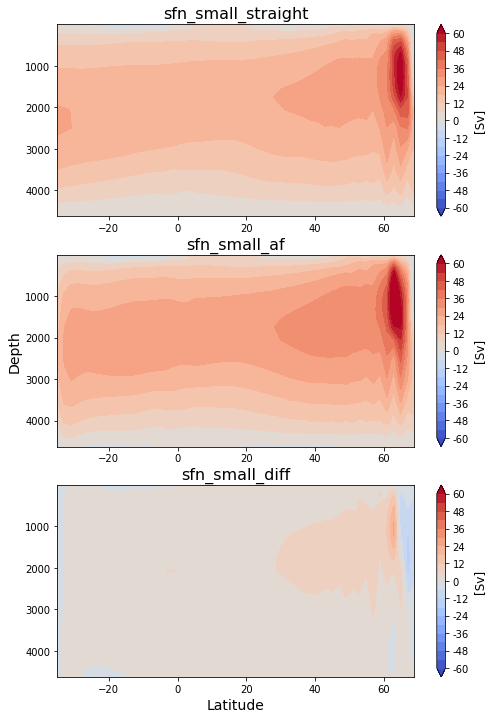

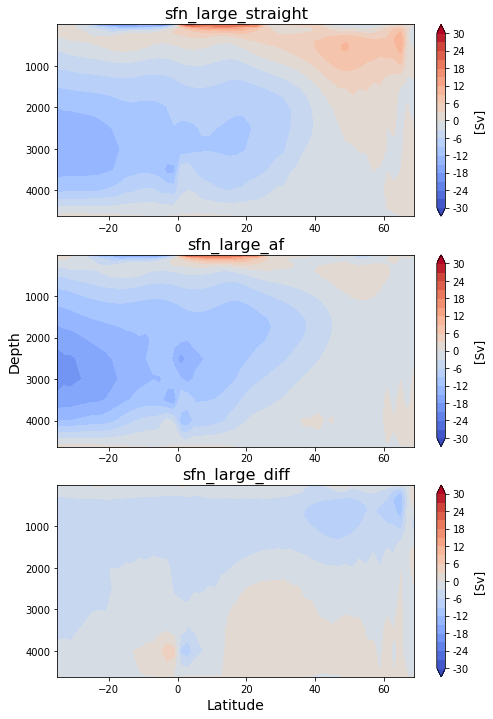

In [18]:
x, x, sfn_small_af = calculate_basin_sfn(dy_af['vmo'], dy_af['vhGM'], x_west, x_east, y, y_north)
x, x, sfn_large_af = calculate_basin_sfn(dy_af['vmo'], dy_af['vhGM'], 0, x_west, y, y_north)

sfn_small_diff = sfn_small_af - sfn_small_straight
sfn_large_diff = sfn_large_af - sfn_large_straight

plot_basin_sfn(sfn_small_straight, sfn_small_af, sfn_small_diff, 60, y, y_north)
plot_basin_sfn(sfn_large_straight, sfn_large_af, sfn_large_diff, 30, y, y_north)

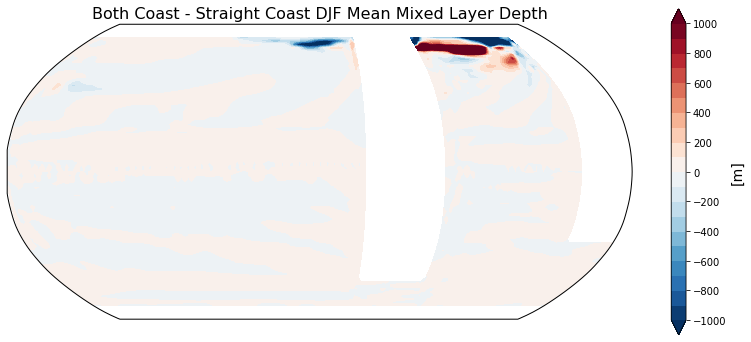

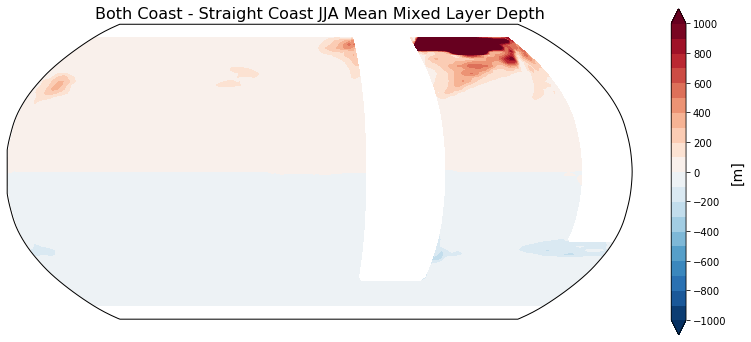

In [19]:
mld_straight = dm_straight['mlotst'][-31:,:,:]
mld_djf_straight = np.nanmean(mld_straight.where(dm_straight['time.season'] == 'DJF'), axis=0)
mld_jja_straight = np.nanmean(mld_straight.where(dm_straight['time.season'] == 'JJA'), axis=0)
mld_both = dm_both['mlotst'][-31:,:,:]
mld_djf_both = np.nanmean(mld_both.where(dm_both['time.season'] == 'DJF'), axis=0)
mld_jja_both = np.nanmean(mld_both.where(dm_both['time.season'] == 'JJA'), axis=0)

mld_djf = mld_djf_both - mld_djf_straight
mld_jja = mld_djf_both - mld_jja_straight

b = np.linspace(-1000, 1000, 21, endpoint=True)
t = np.linspace(-1000, 1000, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dm_straight['xh'], dm_straight['yh'], mld_djf, b, extend='both', 
             cmap='RdBu_r', transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} - {} DJF Mean Mixed Layer Depth'.format(case_both, case_straight), fontsize=16)
# plt.savefig(fig_path+'MLD_DJF.png')
plt.show()

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dm_straight['xh'], dm_straight['yh'], mld_jja, b, extend='both',
             cmap='RdBu_r', transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[m]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} - {} JJA Mean Mixed Layer Depth'.format(case_both, case_straight), fontsize=16)
# plt.savefig(fig_path+'MLD_JJA.png')
plt.show()

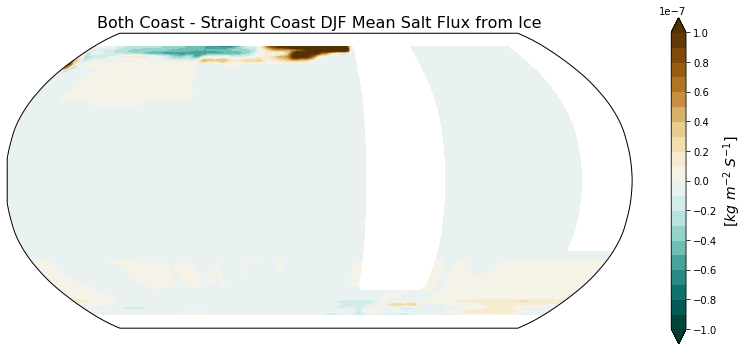

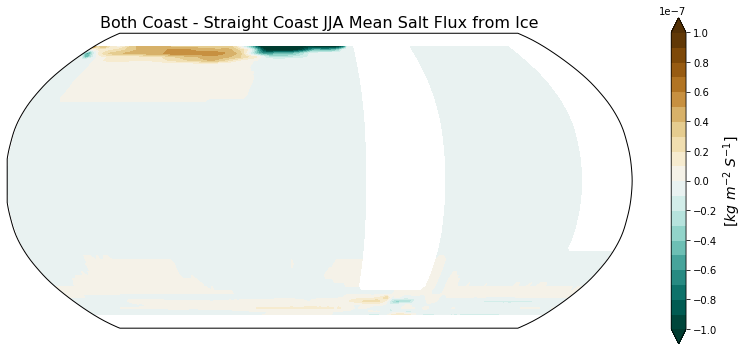

In [20]:
SALTF_straight = di_straight['SALTF'][-31:,:,:]
SALTF_djf_straight = np.nanmean(SALTF_straight.where(di_straight['time.season'] == 'DJF'), axis=0)
SALTF_jja_straight = np.nanmean(SALTF_straight.where(di_straight['time.season'] == 'JJA'), axis=0)
SALTF_both = di_both['SALTF'][-31:,:,:]
SALTF_djf_both = np.nanmean(SALTF_both.where(di_both['time.season'] == 'DJF'), axis=0)
SALTF_jja_both = np.nanmean(SALTF_both.where(di_both['time.season'] == 'JJA'), axis=0)

SALTF_djf = SALTF_djf_both - SALTF_djf_straight
SALTF_jja = SALTF_jja_both - SALTF_jja_straight

b = np.linspace(-1e-7, 1e-7, 21, endpoint=True)
t = np.linspace(-1e-7, 1e-7, 11, endpoint=True)

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(di_straight['xT'], di_straight['yT'], SALTF_djf, b, cmap='BrBG_r',
             extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel(r'$[kg\ m^{-2}\ S^{-1}]$', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} - {} DJF Mean Salt Flux from Ice'.format(case_both, case_straight), fontsize=16)
# plt.savefig(fig_path+'MLD_DJF.png')
plt.show()

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(di_straight['xT'], di_straight['yT'], SALTF_jja, b, cmap='BrBG_r',
             extend='both',  transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel(r'$[kg\ m^{-2}\ S^{-1}]$', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} - {} JJA Mean Salt Flux from Ice'.format(case_both, case_straight), fontsize=16)
# plt.savefig(fig_path+'MLD_JJA.png')
plt.show()